# Chapter 3 — Interactive Companion: Scalar Mixing


This is a companion notebook for Chapter 3. It includes mixing-length theory, Van Driest damping,
steady diffusion-form solvers, buoyancy/stability widgets, a density-current demo, synthetic shear data, self-assessment, and homework.

## 0. Core equations
Mixing length closure:
$$\nu_t=\ell_m^2\left|\frac{\partial U}{\partial y}\right|,\qquad \kappa_t=\frac{\nu_t}{Pr_t}.$$
Scalar flux & variance production:
$$q_y=-\kappa_t\,\overline{T}_y,\qquad P_\theta=2\,\kappa_t\,\overline{T}_y^2.$$
1D diffusion form:
$$\partial_t U=\partial_y[(\nu+\nu_t)U_y],\qquad \partial_t \overline{T}=\partial_y[(\alpha+\kappa_t)\overline{T}_y].$$

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider
import ch3_scalar_mixing as ch3
pd.options.display.float_format = "{:.6g}".format
print("Setup complete.")

Setup complete.


## A. Shear-driven mixing — Mixing-length model
Outer scaling $\ell_m\approx \kappa y$; closure $\nu_t=\ell_m^2|U_y|$, $\kappa_t=\nu_t/Pr_t$.

In [19]:
def shear_demo(L=1.0, n=200, kappa=0.41, y0=0.0, wall_damp=False, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1,
               shear_profile='Exponential decay', S0=20.0, decay=0.3, const_S=15.0, Pr_t=0.9, dTdy0=-40.0):
    y = np.linspace(0, L, int(n))
    lm = ch3.van_driest_damping(y,u_tau,nu,A_plus,kappa,m) if wall_damp else ch3.mixing_length_linear(y,kappa,y0)
    dUdy = S0*np.exp(-y/decay) if shear_profile=='Exponential decay' else np.full_like(y,const_S)
    nu_t = ch3.eddy_viscosity(lm, dUdy)
    kappa_t = ch3.eddy_diffusivity(nu_t, Pr_t)
    dTdy = dTdy0*(1 - y/L)
    q_y = -kappa_t*dTdy
    P_theta = 2.0*kappa_t*(dTdy**2)

    plt.figure(); plt.plot(y, lm); plt.xlabel("y"); plt.ylabel("ℓ_m (m)"); plt.title("Mixing length"); plt.show()
    plt.figure(); plt.plot(y, dUdy); plt.xlabel("y"); plt.ylabel("S (1/s)"); plt.title("Shear"); plt.show()
    plt.figure(); plt.plot(y, nu_t); plt.xlabel("y"); plt.ylabel("ν_t (m²/s)"); plt.title("Eddy viscosity"); plt.show()
    plt.figure(); plt.plot(y, kappa_t); plt.xlabel("y"); plt.ylabel("κ_t (m²/s)"); plt.title("Eddy diffusivity"); plt.show()
    plt.figure(); plt.plot(y, q_y); plt.xlabel("y"); plt.ylabel("q_y"); plt.title("Scalar flux"); plt.show()
    plt.figure(); plt.plot(y, P_theta); plt.xlabel("y"); plt.ylabel("P_θ"); plt.title("Scalar-variance production"); plt.show()

interact(
    shear_demo,
    L=FloatSlider(value=1.0, min=0.2, max=5.0, step=0.1, description="L"),
    n=IntSlider(value=200, min=50, max=800, step=10, description="n"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
    y0=FloatSlider(value=0.0, min=0.0, max=0.1, step=0.005, description="y0"),
    wall_damp=Dropdown(options=[False, True], value=False, description="Van Driest"),
    u_tau=FloatSlider(value=0.05, min=0.01, max=0.5, step=0.01, description="u_τ"),
    nu=FloatSlider(value=1.5e-5, min=1e-6, max=5e-5, step=1e-6, description="ν"),
    A_plus=FloatSlider(value=26.0, min=5.0, max=40.0, step=1.0, description="A⁺"),
    m=IntSlider(value=1, min=1, max=2, step=1, description="m"),
    shear_profile=Dropdown(options=['Exponential decay','Constant'], value='Exponential decay', description='Shear'),
    S0=FloatSlider(value=20.0, min=1.0, max=50.0, step=1.0, description="S0"),
    decay=FloatSlider(value=0.3, min=0.05, max=1.5, step=0.05, description="decay"),
    const_S=FloatSlider(value=15.0, min=1.0, max=50.0, step=1.0, description="S const"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=1.5, step=0.05, description="Pr_t"),
    dTdy0=FloatSlider(value=-40.0, min=-200.0, max=0.0, step=5.0, description="∂T/∂y@0")
);

interactive(children=(FloatSlider(value=1.0, description='L', max=5.0, min=0.2), IntSlider(value=200, descript…

### A.1 Theory — Linear mixing length and Van Driest damping
$y^+=yu_\tau/\nu$,
$$\ell_m=\kappa y\left[1-\exp\!\left(-\frac{y^+}{A^+}\right)\right]^m.$$
As $y^+\to0$, $\ell_m\propto y^{1+m}$; as $y^+\to\infty$, $\ell_m\to\kappa y$.

In [20]:
def vd_ell_m(y, kappa=0.41, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1):
    y = np.asarray(y); y_plus = y*u_tau/nu
    return kappa*y*(1.0 - np.exp(-y_plus/A_plus))**m

def demo_vd(L=0.1, n=400, kappa=0.41, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1,
            shear='Constant', S0=500.0, decay=0.02):
    y = np.linspace(0, L, int(n))
    lm_linear = kappa*y
    lm_vd = vd_ell_m(y, kappa, u_tau, nu, A_plus, m)
    dUdy = np.full_like(y, S0) if shear=='Constant' else S0*np.exp(-y/decay)
    nu_t_linear = ch3.eddy_viscosity(lm_linear, dUdy)
    nu_t_vd     = ch3.eddy_viscosity(lm_vd, dUdy)
    plt.figure(); plt.plot(y, lm_linear, label="ℓ_m=κy"); plt.plot(y, lm_vd, label="Van Driest"); plt.xlabel("y"); plt.ylabel("ℓ_m"); plt.title("Mixing length"); plt.legend(); plt.show()
    plt.figure(); plt.semilogy(y, np.maximum(nu_t_linear,1e-12), label="ν_t (κy)"); plt.semilogy(y, np.maximum(nu_t_vd,1e-12), label="ν_t (VD)"); plt.xlabel("y"); plt.ylabel("ν_t"); plt.title("Eddy viscosity"); plt.legend(); plt.show()

interact(
    demo_vd,
    L=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="L (m)"),
    n=IntSlider(value=400, min=100, max=1200, step=50, description="n"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
    u_tau=FloatSlider(value=0.05, min=0.01, max=0.5, step=0.01, description="u_τ"),
    nu=FloatSlider(value=1.5e-5, min=5e-7, max=5e-5, step=5e-7, description="ν"),
    A_plus=FloatSlider(value=26.0, min=10.0, max=40.0, step=1.0, description="A⁺"),
    m=IntSlider(value=1, min=1, max=2, step=1, description="m"),
    shear=Dropdown(options=['Constant','Exponential'], value='Constant', description='Shear'),
    S0=FloatSlider(value=500.0, min=50.0, max=2000.0, step=50.0, description="S₀"),
    decay=FloatSlider(value=0.02, min=0.005, max=0.2, step=0.005, description="decay"),
);

interactive(children=(FloatSlider(value=0.1, description='L (m)', max=0.5, min=0.02, step=0.01), IntSlider(val…

## B. Steady diffusion-form solvers (1D)

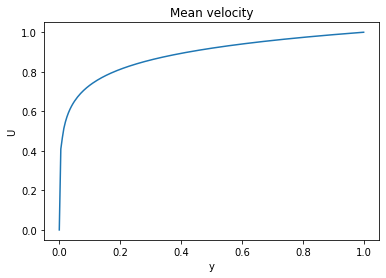

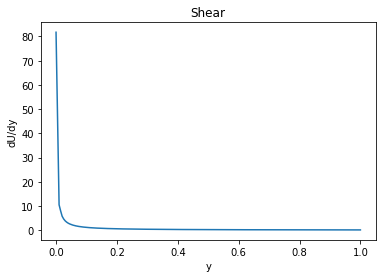

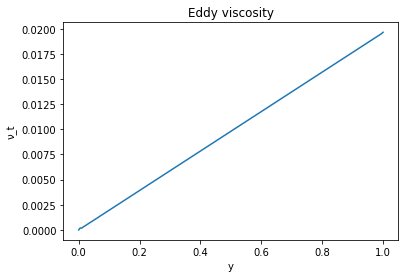

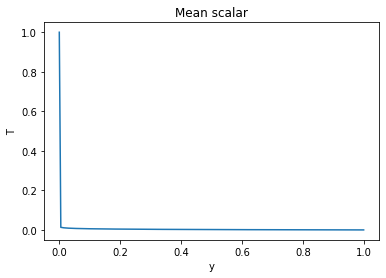

In [21]:
def solve_steady_diffusion(y, mu_eff, bc0, bc1):
    y = np.asarray(y); mu = np.asarray(mu_eff); n = len(y); dy = y[1]-y[0]
    A = np.zeros((n,n)); b = np.zeros(n); A[0,0]=1; b[0]=bc0; A[-1,-1]=1; b[-1]=bc1
    for i in range(1,n-1):
        mu_w = 2*mu[i-1]*mu[i]/(mu[i-1]+mu[i]); mu_e = 2*mu[i]*mu[i+1]/(mu[i]+mu[i+1])
        A[i,i-1]= mu_w/(dy*dy); A[i,i]=-(mu_w+mu_e)/(dy*dy); A[i,i+1]= mu_e/(dy*dy)
    return np.linalg.solve(A,b)

def momentum_scalar_solver(n=201, L=1.0, nu=1.5e-5, alpha=1.4e-7, kappa=0.41, Pr_t=0.9,
                           U0=0.0, U1=1.0, T0=1.0, T1=0.0, max_iter=30):
    y = np.linspace(0, L, int(n)); U = np.linspace(U0, U1, int(n))
    for _ in range(int(max_iter)):
        dUdy = np.gradient(U, y); lm = kappa*y; nu_t = (lm**2)*np.abs(dUdy); mu_eff = nu + nu_t
        U_new = solve_steady_diffusion(y, mu_eff, U0, U1)
        if np.max(np.abs(U_new-U))<1e-6: U=U_new; break
        U = 0.5*U + 0.5*U_new
    kappa_t = nu_t/Pr_t; alpha_eff = alpha + kappa_t; T = solve_steady_diffusion(y, alpha_eff, T0, T1)
    plt.figure(); plt.plot(y,U); plt.xlabel("y"); plt.ylabel("U"); plt.title("Mean velocity"); plt.show()
    plt.figure(); plt.plot(y,np.gradient(U,y)); plt.xlabel("y"); plt.ylabel("dU/dy"); plt.title("Shear"); plt.show()
    plt.figure(); plt.plot(y,nu_t); plt.xlabel("y"); plt.ylabel("ν_t"); plt.title("Eddy viscosity"); plt.show()
    plt.figure(); plt.plot(y,T); plt.xlabel("y"); plt.ylabel("T"); plt.title("Mean scalar"); plt.show()

momentum_scalar_solver()

## C. Buoyancy effects — $N^2$ and $Ri_g$

In [22]:
from ipywidgets import interact
def buoy_demo(L=1.0, n=300, S0=10.0, decay=0.4, N2_0=0.02, N2_slope=0.0, Pr_t=0.9, kappa=0.41):
    y = np.linspace(0, L, int(n)); dUdy = S0*np.exp(-y/decay); lm = kappa*y; nu_t=(lm**2)*np.abs(dUdy); kappa_t=nu_t/Pr_t
    N2 = N2_0 + N2_slope*(y - L/2.0); Ri_g = N2/np.maximum(dUdy**2, 1e-12)
    plt.figure(); plt.plot(y,N2); plt.xlabel("y"); plt.ylabel("N²"); plt.title("Stability"); plt.show()
    plt.figure(); plt.plot(y,Ri_g); plt.xlabel("y"); plt.ylabel("Ri_g"); plt.title("Gradient Richardson"); plt.show()
    plt.figure(); plt.plot(y,kappa_t); plt.xlabel("y"); plt.ylabel("κ_t"); plt.title("Eddy diffusivity"); plt.show()

interact(
    buoy_demo,
    L=FloatSlider(value=1.0, min=0.2, max=5.0, step=0.1, description="L"),
    n=IntSlider(value=300, min=50, max=800, step=10, description="n"),
    S0=FloatSlider(value=10.0, min=0.5, max=40.0, step=0.5, description="S0"),
    decay=FloatSlider(value=0.4, min=0.05, max=2.0, step=0.05, description="decay"),
    N2_0=FloatSlider(value=0.02, min=-0.05, max=0.1, step=0.005, description="N² @ mid"),
    N2_slope=FloatSlider(value=0.0, min=-0.2, max=0.2, step=0.005, description="N² slope"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=1.5, step=0.05, description="Pr_t"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
);

interactive(children=(FloatSlider(value=1.0, description='L', max=5.0, min=0.2), IntSlider(value=300, descript…

## D. Density current (gravity current) — interactive example

In [23]:
from ipywidgets import FloatSlider, IntSlider
g = 9.81
def density_current_demo(L=200.0, n=400, rho0=1000.0, drho=2.0, h0=0.5, Fr=0.9, E=0.02, kappa=0.41, gamma=0.1, Pr_t=0.9):
    x = np.linspace(0, L, int(n)); h = h0 + E*x; gprime = g*(drho/rho0); U = Fr*np.sqrt(np.maximum(gprime*h, 1e-12))
    DeltaC0 = 1.0; DeltaC = DeltaC0*(h0/h); S = np.maximum(U/np.maximum(h,1e-12),1e-12); ell_m = gamma*h
    nu_t=(ell_m**2)*S; kappa_t=nu_t/Pr_t; delta = gamma*h; q = -kappa_t*(DeltaC/np.maximum(delta,1e-12))
    plt.figure(); plt.plot(x,h); plt.xlabel("x"); plt.ylabel("h"); plt.title("Layer thickness"); plt.show()
    plt.figure(); plt.plot(x,U); plt.xlabel("x"); plt.ylabel("U"); plt.title("Front speed scale"); plt.show()
    plt.figure(); plt.plot(x,DeltaC); plt.xlabel("x"); plt.ylabel("ΔC"); plt.title("Dilution"); plt.show()
    plt.figure(); plt.plot(x,kappa_t); plt.xlabel("x"); plt.ylabel("κ_t"); plt.title("Eddy diffusivity"); plt.show()
    plt.figure(); plt.plot(x,q); plt.xlabel("x"); plt.ylabel("q"); plt.title("Flux proxy"); plt.show()
interact(density_current_demo,
         L=FloatSlider(value=200.0, min=20.0, max=2000.0, step=10.0, description="L"),
         n=IntSlider(value=400, min=100, max=2000, step=50, description="n"),
         rho0=FloatSlider(value=1000.0, min=900.0, max=1030.0, step=1.0, description="ρ0"),
         drho=FloatSlider(value=2.0, min=0.1, max=20.0, step=0.1, description="Δρ"),
         h0=FloatSlider(value=0.5, min=0.05, max=5.0, step=0.05, description="h0"),
         Fr=FloatSlider(value=0.9, min=0.2, max=1.5, step=0.05, description="Fr"),
         E=FloatSlider(value=0.02, min=0.0, max=0.2, step=0.005, description="E"),
         kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
         gamma=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="γ"),
         Pr_t=FloatSlider(value=0.9, min=0.5, max=2.0, step=0.05, description="Pr_t"),
);

interactive(children=(FloatSlider(value=200.0, description='L', max=2000.0, min=20.0, step=10.0), IntSlider(va…

## E. Synthetic shear data examples

In [24]:
import pandas as pd
y = np.linspace(0, 1, 201); lm = 0.1*y; dUdy = 20.0*np.exp(-y/0.3); Pr_t = 0.9; dTdy = -30.0*(1 - y)
nu_t=(lm**2)*np.abs(dUdy); kappa_t=nu_t/Pr_t; q_y=-kappa_t*dTdy; P_theta=2.0*kappa_t*(dTdy**2)
toy = pd.DataFrame({"y":y,"lm_m":lm,"S_1_per_s":dUdy,"Pr_t":Pr_t,"nu_t_m2_per_s":nu_t,"kappa_t_m2_per_s":kappa_t,
                    "dTdy_K_per_m":dTdy,"q_y_K_m_per_s":q_y,"P_theta_K2_per_s":P_theta})
toy.head()

,y,lm_m,S_1_per_s,Pr_t,nu_t_m2_per_s,kappa_t_m2_per_s,dTdy_K_per_m,q_y_K_m_per_s,P_theta_K2_per_s
0,0,0,20,0.9,0,0,-30,0,0
1,0.005,0.0005,19.6694,0.9,4.91736e-06,5.46373e-06,-29.85,0.000163092,0.00973661
2,0.01,0.001,19.3443,0.9,1.93443e-05,2.14937e-05,-29.7,0.000638363,0.0379187
3,0.015,0.0015,19.0246,0.9,4.28053e-05,4.75615e-05,-29.55,0.00140544,0.0830616
4,0.02,0.002,18.7101,0.9,7.48406e-05,8.31562e-05,-29.4,0.00244479,0.143754


In [25]:
# Add noise & save CSV
rng=np.random.default_rng(42); nl=0.03
lm_n=lm*(1+nl*rng.standard_normal(lm.shape)); dUdy_n=dUdy*(1+nl*rng.standard_normal(dUdy.shape)); dTdy_n=dTdy*(1+nl*rng.standard_normal(dTdy.shape))
nu_t_n=(lm_n**2)*np.abs(dUdy_n); kappa_t_n=nu_t_n/Pr_t; q_y_n=-kappa_t_n*dTdy_n; P_theta_n=2.0*kappa_t_n*(dTdy_n**2)
syn=pd.DataFrame({"y":y,"lm_m":lm_n,"S_1_per_s":dUdy_n,"Pr_t":Pr_t,"nu_t_m2_per_s":nu_t_n,"kappa_t_m2_per_s":kappa_t_n,
                  "dTdy_K_per_m":dTdy_n,"q_y_K_m_per_s":q_y_n,"P_theta_K2_per_s":P_theta_n})
syn.to_csv("Synthetic_ShearDemo.csv", index=False); print("Saved Synthetic_ShearDemo.csv"); syn.head()

Saved Synthetic_ShearDemo.csv


,y,lm_m,S_1_per_s,Pr_t,nu_t_m2_per_s,kappa_t_m2_per_s,dTdy_K_per_m,q_y_K_m_per_s,P_theta_K2_per_s
0,0,0,20.8445,0.9,0,0,-30.7385,0,0
1,0.005,0.0004844,19.7229,0.9,4.62785e-06,5.14205e-06,-29.4974,0.000151677,0.00894817
2,0.01,0.00102251,19.718,0.9,2.06159e-05,2.29065e-05,-30.1644,0.00069096,0.0416847
3,0.015,0.00154233,17.8545,0.9,4.24717e-05,4.71907e-05,-29.3143,0.00138336,0.0811048
4,0.02,0.00188294,18.6828,0.9,6.6239e-05,7.35989e-05,-29.2963,0.00215618,0.126336


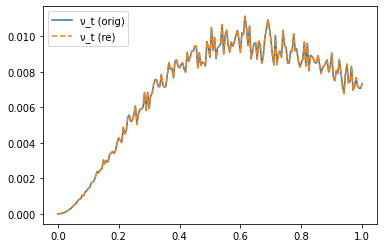

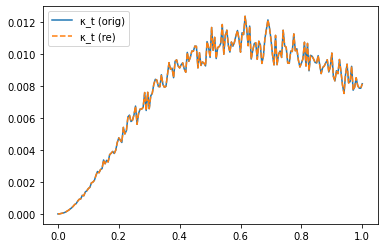

In [26]:
# Reconstruct & compare
nu_t_re=(syn["lm_m"].values**2)*np.abs(syn["S_1_per_s"].values); kappa_re=nu_t_re/Pr_t
import matplotlib.pyplot as plt
plt.figure(); plt.plot(syn["y"],syn["nu_t_m2_per_s"],label="ν_t (orig)"); plt.plot(syn["y"],nu_t_re,'--',label="ν_t (re)"); plt.legend(); plt.show()
plt.figure(); plt.plot(syn["y"],syn["kappa_t_m2_per_s"],label="κ_t (orig)"); plt.plot(syn["y"],kappa_re,'--',label="κ_t (re)"); plt.legend(); plt.show()

## F. Self‑assessment & G. Homework


## Homework — Scalar Mixing (Chapter 3)

1) Mixing length → νₜ, κₜ, qᵧ, P_θ(Section A: Shear-driven mixing widget)
Set κ=0.41, Prₜ=0.9, **Exponential** shear with S₀=20 s⁻¹, decay=0.3 m; **no Van Driest**.
Deliverables:* Plots of ℓₘ(y), νₜ(y), κₜ(y), qᵧ(y), P_θ(y) + a paragraph: where is P_θ largest and why?
Extension:* Repeat with Van Driest (u_τ=0.05 m/s, A⁺=26); compare νₜ near the wall.

2) Van Driest sensitivity (m = 1 vs 2)(Section A.1 demo)
L=0.1 m, Constant shear S₀=500 s⁻¹; sweep A⁺∈{12,26,40}, m∈{1,2}.
Deliverables:* Overlay νₜ(y) (6 curves); table of νₜ at y=0.5 mm and 1 mm; conclude which parameter controls near‑wall turn‑on.

3) Steady diffusion-form momentum & scalar(Section B)
ν=1.5e−5 m²/s, α=1.4e−7 m²/s, κ=0.41, Prₜ=0.9. Solve U(y) on L=1 m with U(0)=0, U(1)=1; then T(y) with T(0)=1, T(1)=0.
Deliverables:* U(y), dU/dy, νₜ(y), T(y) plots. Explain why T(y) departs from linear when κₜ ≫ α.

4) Stability & eddy diffusivity(Section C)
S₀=10 s⁻¹, decay=0.4 m, Prₜ=0.9. Try N²: +0.02, 0, −0.02 s⁻².
Deliverables:* N²(y), Ri_g(y), κₜ(y) plots. Mark Ri_g>0.25 and discuss κₜ behavior.

5) Density current knobs(Section D)
Baseline: ρ₀=1000 kg/m³, Δρ=2 kg/m³, h₀=0.5 m, Fr=0.9, E=0.02, γ=0.1, Prₜ=0.9. Then set E=0.04.
Deliverables:* h(x), U(x), ΔC(x), κₜ(x), q(x) for both; explain how entrainment changes flux magnitude.

6) Synthetic shear data: noise & reconstruction(Section E)
Run E.1/E.2/E.3; noise = 0%, 3%, 10%.
Deliverables:* Plots comparing original vs reconstructed νₜ, κₜ; paragraph on which quantity is most noise‑sensitive and why.

